<a href="https://colab.research.google.com/github/ilMassy/Progetto-Machine-Learning/blob/main/Progetto_Machine_Learning_dataset_SDSS17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# importo le librerie fondamentali
import pandas as pd
# per standardizzazione
from sklearn.preprocessing import StandardScaler
# per i grafici
import matplotlib.pyplot as plt
import seaborn as sns
# per l'Autoencoder (feature learning)
import tensorflow as tf
from keras import layers, models
# per la divisione dati train test
from sklearn.model_selection import train_test_split
# per PCA (riduzione di dimensionalità)
from sklearn.decomposition import PCA
# utile per il calcolo della varianza cumulativa
import numpy as np
# per applicare il SVM
from sklearn.svm import SVC

1. CARICAMENTO DEL DATASET

In [3]:
path = "/content/drive/MyDrive/Dataset/star_classification.csv"
df = pd.read_csv(path)
# visualizzo il dataframe
df

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


<Axes: xlabel='class', ylabel='count'>

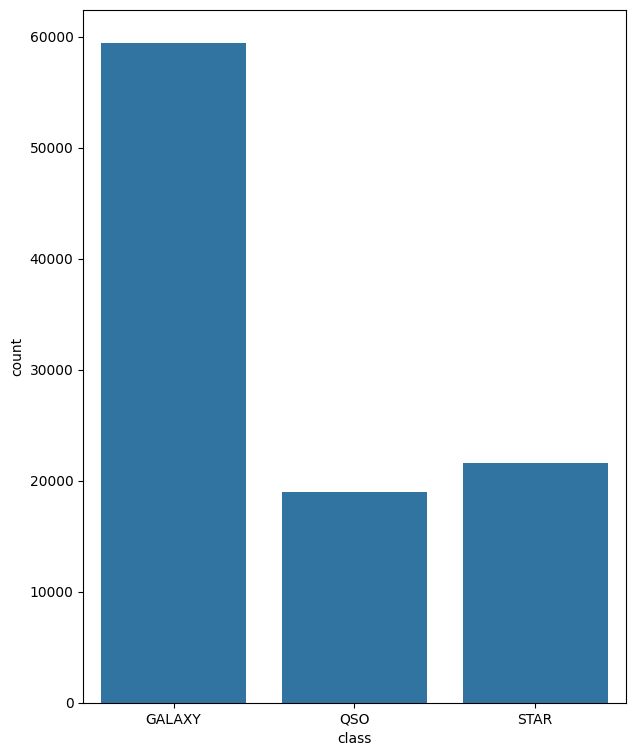

In [4]:
# visualizzo il countplot relativo alla colonna target "class"
plt.figure(figsize=(7,9))
sns.countplot(data=df,x="class")

2. PREPROCESSAMENTO DEI DATI

2.1 RIMOZIONE COLONNE NON NECESSARIE

In [5]:
# rimuovo le colonne non necessarie, in questo caso gli id e cam_col
# (Camera Column)
if "obj_ID" in df.columns.values:
    df.drop(["obj_ID", "run_ID", "rerun_ID", "cam_col", "field_ID", "spec_obj_ID", "fiber_ID"],axis=1,inplace=True)

df

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187
...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000,9374,57749
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895,7626,56934
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366,2764,54535
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040,6751,56368


2.2 RIMOZIONE DEGLI OUTLAYERS

In [6]:
# funzione che ritorna gli indici delle colonne float e int
colums = df.select_dtypes(include=['float64', 'int64']).columns

<Axes: >

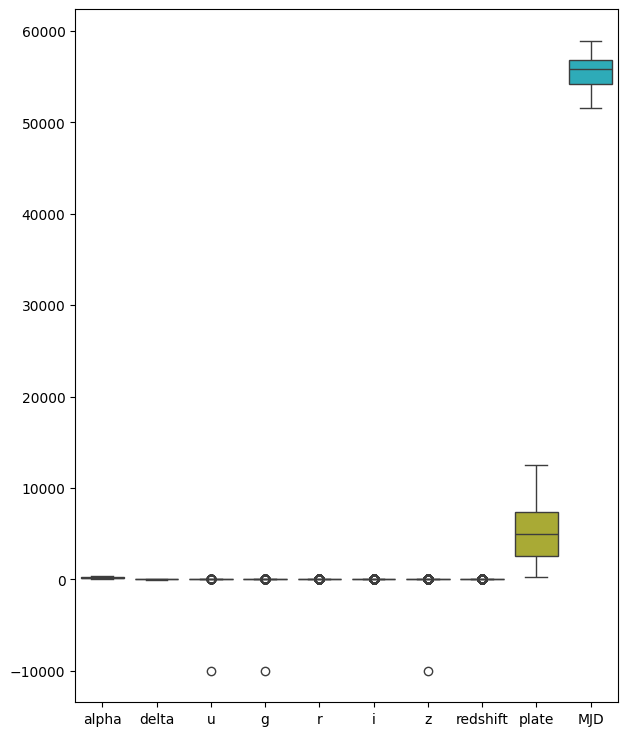

In [7]:
# tramite uno box plot visualizzo la distribuzione dei punti prima della
# rimozione degli outlayers
plt.figure(figsize=(7, 9)) # 7 pollici di larghezza, 9 di altezza
sns.boxplot(data=df)

In [8]:
# stampo il numero di righe del dataframe prima della rimozione
print('numero righe prima della rimozione degli outlayers:', len(df))

# rimuovo i valori che si discostano eccessivamente dalla distribuzione dei dati

# utilizzo l'interquartile range per identificarli e rimuoverli
def detect_outliers_iqr(df):
    outliers_indices = []

    for column in colums:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        lower_bound = Q1 - 1.5 * (Q3 - Q1)
        upper_bound = Q3 + 1.5 * (Q3 - Q1)

        # identifico gli indici degli outlier, righe
        outliers_list_col = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        # con extend aggiungo all'array ouliers_indices, inizialmente vuoto,
        # gli indici delle righe che presentano outlayers
        outliers_indices.extend(outliers_list_col)

    outliers_indices = list(set(outliers_indices))  # rimuovo i duplicati
    return outliers_indices

outliers_indices = detect_outliers_iqr(df)

# rimuovo gli outlayers
df.drop(outliers_indices,axis=0,inplace=True)

# stampo il numero di righe del dataframe dopo la rimozione
print('numero righe dopo la rimozione degli outlayers:', len(df))

numero righe prima della rimozione degli outlayers: 100000
numero righe dopo la rimozione degli outlayers: 90632


<Axes: >

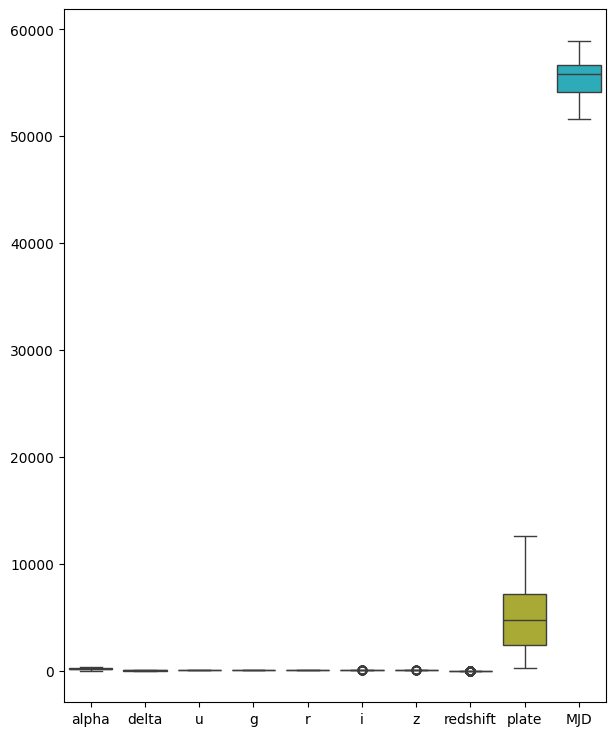

In [ ]:
# stampo il box plot dopo la rimozione degli outlayers
plt.figure(figsize=(7, 9))
sns.boxplot(data=df)

# come si può notare i punti bianchi isolati sono spariti

In [ ]:
# stampo il dataset
df

,alpha,delta,u,g,r,i,z,class,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,6121,56187
...,...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000,9374,57749
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895,7626,56934
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366,2764,54535
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040,6751,56368


2.3 SEPARAZIONE DATI DAL TARGET

In [ ]:
# in questa fase separo dal dataset il target (cioè l'etichetta), in questo
# caso è la colonna "class"

# necessario per la standardizzazione, IN QUESTO CASO, perchè l'unica colonna
# non numerica è la colonna target, che è una stringa
X = df.drop(columns=['class'])
y = df['class']

X

,alpha,delta,u,g,r,i,z,redshift,plate,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,5812,56354
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,10445,58158
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,4576,55592
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346,9149,58039
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,6121,56187
...,...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,9374,57749
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,7626,56934
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,2764,54535
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,6751,56368


2.4 STANDARDIZZAZIONE

In [ ]:
# standardizzazione
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled

array([[-0.4312449 ,  0.43524103,  0.76621227, ...,  0.62107327,
         0.28553265,  0.47702487],
       [-0.33644115,  0.3731644 ,  1.15821072, ...,  0.99305387,
         1.86235539,  1.47139825],
       [-0.3638054 ,  0.59229903,  1.36995277, ...,  0.64530005,
        -0.13513493,  0.05700685],
       ...,
       [ 0.49114726, -0.41896253, -0.41560566, ..., -0.64537156,
        -0.75184178, -0.52561658],
       [ 0.36332984,  1.15576468,  1.40803738, ...,  0.15783445,
         0.60511749,  0.48474174],
       [ 0.20382694,  1.29840101,  0.21792388, ...,  0.38437084,
         0.82940546,  0.89042844]])

3. FEATURE LEARNING

In [ ]:
# costruisco e addestro un Autoencoder
# utilizzo random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)


input_dim = X_train.shape[1]
# dimensionalità dato codificato
encoding_dim = 17

# definisco gli strati dell'Autoencoder
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = models.Model(inputs=input_layer, outputs=decoded)
encoder = models.Model(inputs=input_layer, outputs=encoded)  # solo la parte di encoding

# compilazione del modello, uso la mse come funzione di loss
autoencoder.compile(optimizer='adam', loss='mse')

# addestramento dell'Autoencoder
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_test, X_test),
                          verbose=0)

In [ ]:
# ho addestrato l'autoencoder, quindi lo utilizzo sui dati (train e test)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# verifico se effettivamente la dimensione del dataset codificato è 17
X_train_encoded.shape[1], X_test_encoded.shape[1]

2125/2125 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
709/709 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(17, 17)

2.5 RIDUZIONE DI DIMENSIONALITA'

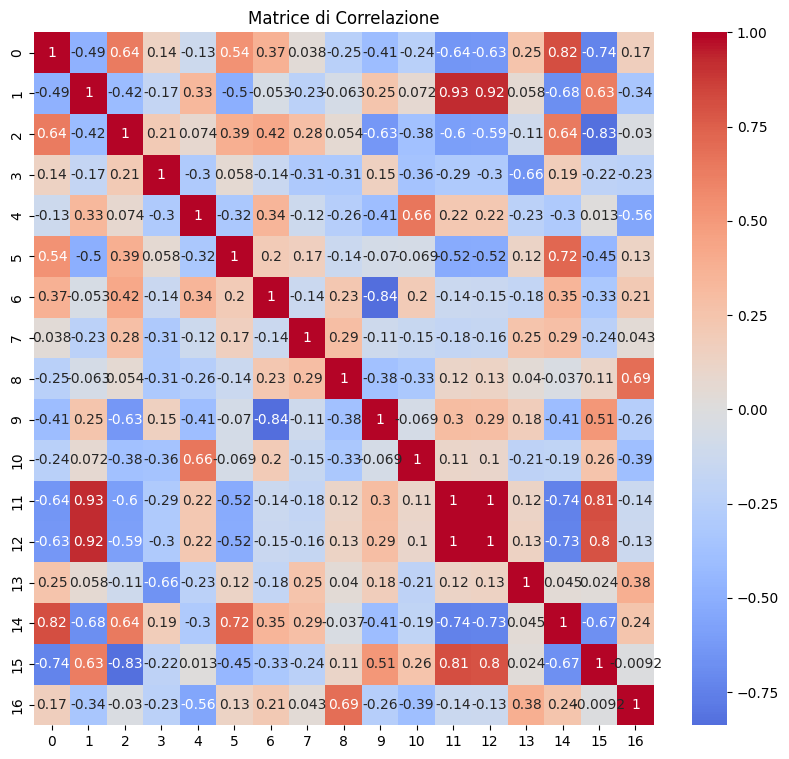

In [ ]:
# calcolo della matrice di correlazione, con l'array di dati codificati
correlation_matrix = np.corrcoef(X_train_encoded, rowvar=False)

# creazione della heatmap (grafico)
plt.figure(figsize=(10, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matrice di Correlazione")
plt.show()



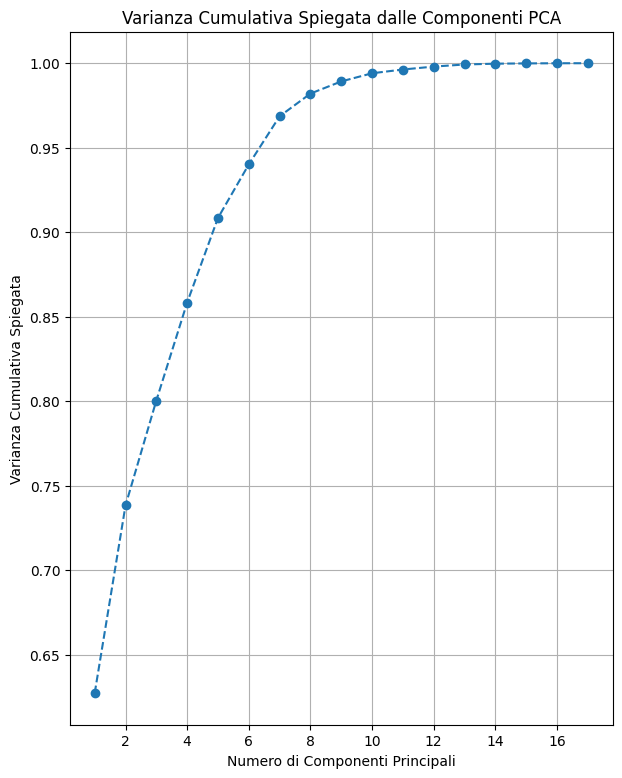

Numero di componenti necessarie per coprire il 97% di varianza: 8


In [ ]:
# utilizzo il metodo PCA
pca = PCA()

pca.fit(X_train_encoded)

# calcolo la varianza spiegata cumulativa
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# visualizzo la varianza spiegata cumulativa
plt.figure(figsize=(7, 9))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Numero di Componenti Principali')
plt.ylabel('Varianza Cumulativa Spiegata')
plt.title('Varianza Cumulativa Spiegata dalle Componenti PCA')
plt.grid(True)
plt.show()

# Determino il numero di componenti necessarie per spiegare, ad esempio,
# il 97% della varianza
num_components = np.argmax(cumulative_variance >= 0.97) + 1
print(f"Numero di componenti necessarie per coprire il 97% di varianza: {num_components}")



In [ ]:
# applico PCA sul numero di componenti che coprono il 97% di varianza
pca = PCA(n_components = num_components)
# fit_trasform restituisce un array e non un dataframe
X_train_reduced = pca.fit_transform(X_train_encoded)

In [ ]:
# ora lo converto in un DataFrame
df_train_reduced = pd.DataFrame(X_train_reduced, columns=[f'PC{i+1}' for i in range(num_components)])

# visualizzo il DataFrame
print(df_train_reduced)

             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0      11.161477  3.323374  1.391018  1.208701  0.484888 -1.463670  0.177657   
1      -4.880794 -0.586620  1.617985 -2.043182  0.559833  0.301547  0.970147   
2      -0.929098 -0.228374 -0.989765  0.789635 -2.091425 -0.087216  0.956848   
3      -1.483458  0.113219 -1.048017  2.245397 -0.721438 -3.583926 -0.824914   
4      -3.531313 -1.237392 -0.969161 -0.764947 -1.032853  1.719772 -0.439225   
...          ...       ...       ...       ...       ...       ...       ...   
67969  -3.972163 -0.192653 -0.988797  0.502026 -0.169203  0.366301 -0.682673   
67970  -5.201689 -0.294342  0.802783 -1.199080  0.412731 -0.309342  2.739123   
67971  -5.497163  0.049376  2.357617 -2.986519  1.896993 -1.750464  1.441196   
67972   8.363407  0.146602  0.253510 -1.077760  0.168724  1.590666  0.500840   
67973   9.366730  2.281260  1.434812 -0.947378 -1.469388  0.546390  0.360473   

            PC8  
0     -0.257766  
1  

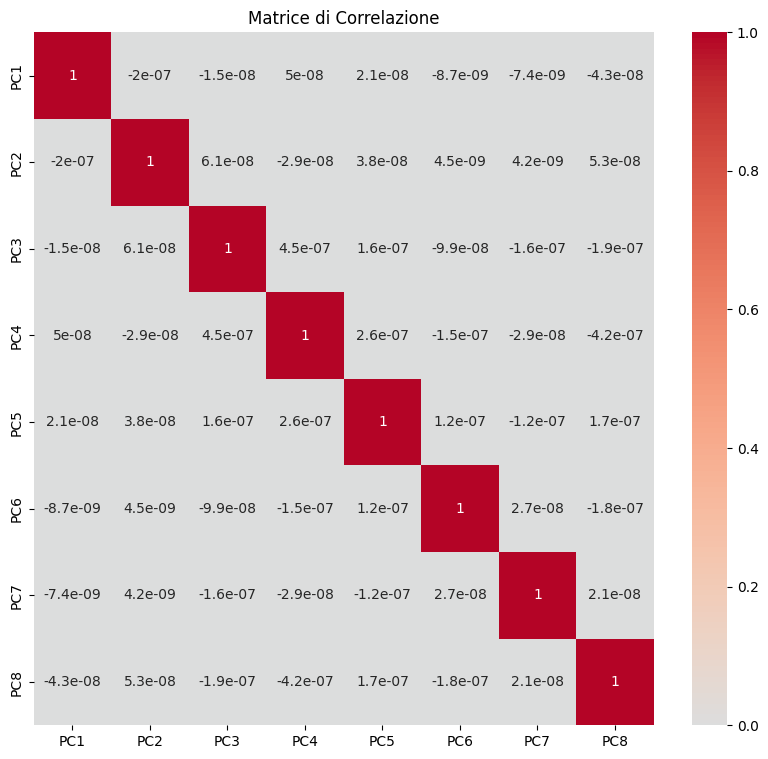

In [ ]:
# ora ricavo la matrice di correlazione, questa volta lo faccio col
# dataframe
corr_matrix = df_train_reduced.corr()

# visualizzo la matrice di correlazione
plt.figure(figsize=(10, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di Correlazione')
plt.show()

# come si può notare la correlazione tra le componenti è notevolmente
# diminuita (centrata sullo 0, e non su 1 o -1)

In [ ]:
# ora applico pca pure sui dati di test ma non il metodo fit_transform
X_test_reduced = pca.transform(X_test_encoded)

# verifico la nuova dimensione
print(f"Nuova dimensione dei dati di test: {X_test_reduced.shape[1]}")

Nuova dimensione dei dati di test: 8


4. METODI KERNEL (SVM, KERNEL TRICK)

In [ ]:
# utilizzo un classificatore SVM con kernel Radial basis function (RBF)
clf = SVC(kernel='rbf')
clf.fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)

# calcolo l'accuratezza
accuracy = clf.score(X_test_reduced, y_test)
print(f"Accuratezza: {accuracy * 100:.2f}%")

Accuratezza: 95.47%
